# CAB420 Assignment 1A Question 3

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import scipy.io
import numpy
# numpy.set_printoptions(threshold=numpy.inf)

import os
import datetime
import pydot
import IPython
from IPython.display import SVG

# Question 1
Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs, class_weights):
    
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        class_weight=class_weights)    
    
    model.load_weights(filename)
    model.save(filename)    
    
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Testing')

In [4]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

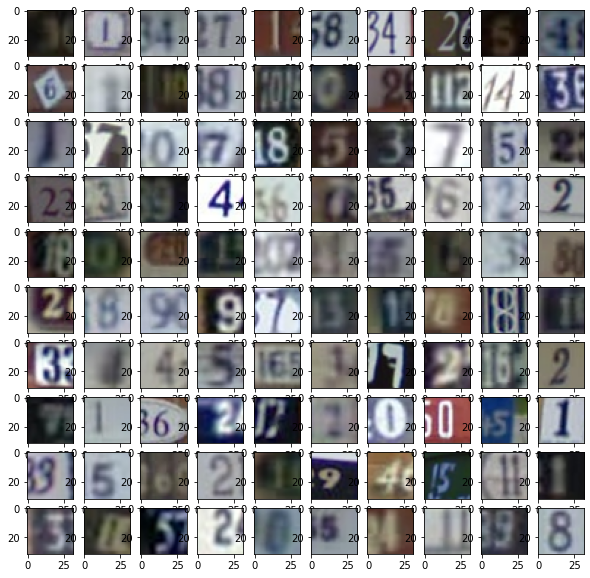

In [5]:
SVHN_train = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_train.mat')
SVHN_test = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_test.mat')
# print(SVHN_test)
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(SVHN_train['train_X'][:,:,:,i])

In [6]:
# Change class from [1 - 10] to [0 - 9] as keras takes 0 - 9

for i in range (len(SVHN_train['train_Y'])):
    SVHN_train['train_Y'][i] = SVHN_train['train_Y'][i] - 1
for i in range (len(SVHN_test['test_Y'])):
    SVHN_test['test_Y'][i] = SVHN_test['test_Y'][i] - 1


In [7]:
# Do we need to preserve rbg value(3) in a 4D, or just put 1 in the end
train = numpy.transpose(SVHN_train['train_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
train_y = SVHN_train['train_Y']
test = numpy.transpose(SVHN_test['test_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
test_y = SVHN_test['test_Y']

class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())

# fig = plt.figure(figsize=[10, 10])
# for i in range(100):
#     ax = fig.add_subplot(10, 10, i + 1)
#     ax.imshow(train[i,:,:,:])

### vgg_2stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.6436 - accuracy: 0.1518
Epoch 00001: val_loss improved from inf to 70.06066, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 18s 18ms/sample - loss: 2.6341 - accuracy: 0.1490 - val_loss: 70.0607 - val_accuracy: 0.1894
Epoch 2/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.2351 - accuracy: 0.2266
Epoch 00002: val_loss improved from 70.06066 to 22.91210, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 14s 14ms/sample - loss: 2.2262 - accuracy: 0.2330 - val_loss: 22.9121 - val_accuracy: 0.1078
Epoch 3/20
 896/1000 [=========================>....] - ETA: 0s - loss: 1.9878 - accuracy: 0.3415
Epoch 00003: val_loss improved from 22.91210 to 8.53336, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 15s 15ms/sample - loss: 1.9913 - accuracy: 0.3450 -

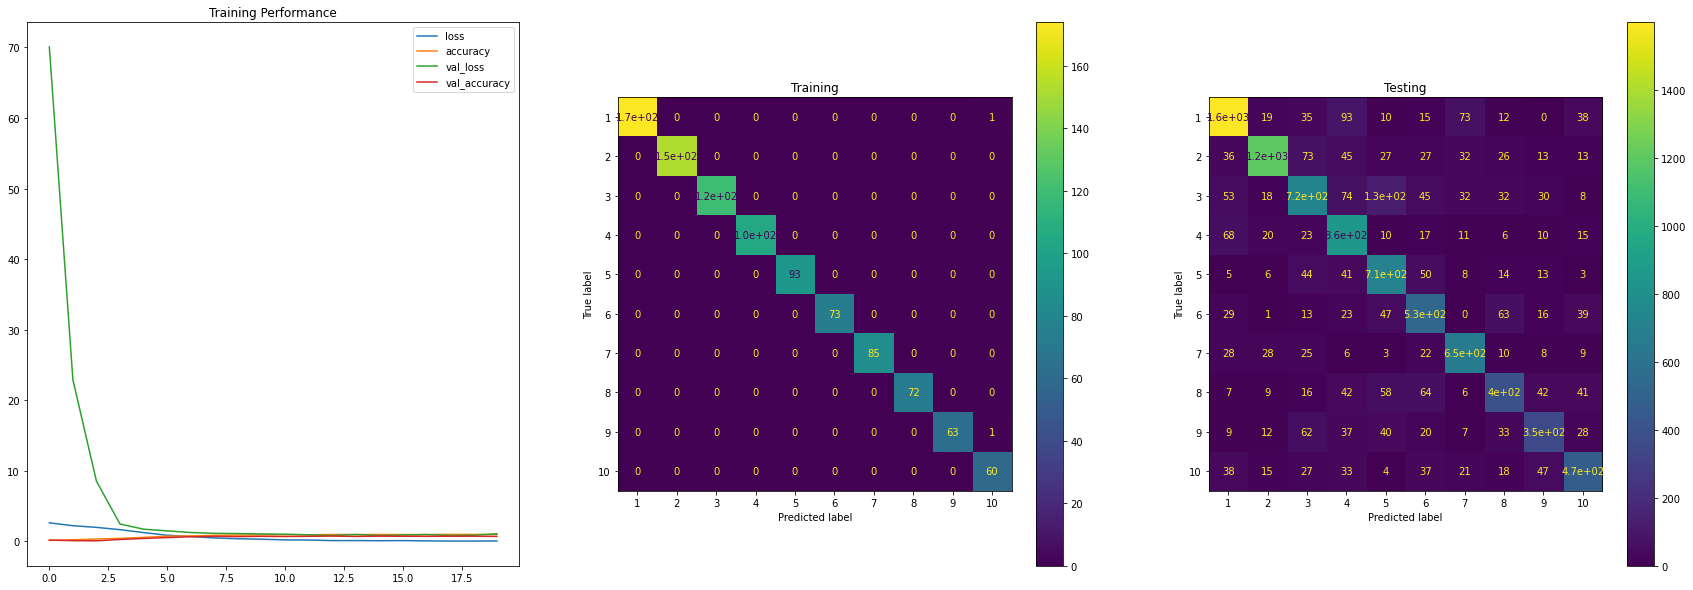

In [8]:
batch_size = 128
num_epochs = 20
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, train, train_y, test, test_y, 'vgg_2stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 11s - loss: 0.8390 - accuracy: 0.7485
Test loss: 0.8390086133956909
Test accuracy: 0.7485


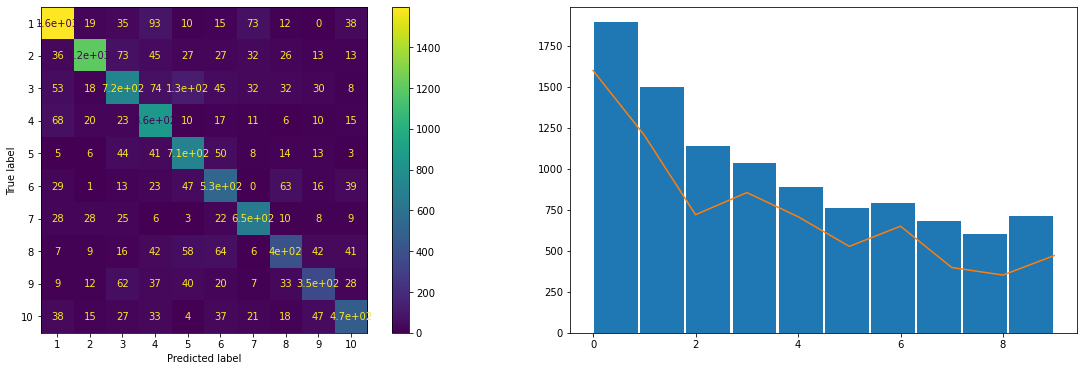

In [9]:
eval_model(model_cnn, test, test_y)

### vgg_3stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.7697 - accuracy: 0.1228
Epoch 00001: val_loss improved from inf to 5.00042, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 17s 17ms/sample - loss: 2.7424 - accuracy: 0.1300 - val_loss: 5.0004 - val_accuracy: 0.1532
Epoch 2/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.3735 - accuracy: 0.1853
Epoch 00002: val_loss did not improve from 5.00042
1000/1000 [==============================] - 14s 14ms/sample - loss: 2.3791 - accuracy: 0.1860 - val_loss: 6.7203 - val_accuracy: 0.0790
Epoch 3/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.2133 - accuracy: 0.2266
Epoch 00003: val_loss improved from 5.00042 to 4.17029, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 15s 15ms/sample - loss: 2.2096 - accuracy: 0.2270 - val_loss: 4.1703 - val_accuracy: 0.1562
Epoch 4/3

 896/1000 [=========================>....] - ETA: 0s - loss: 0.0566 - accuracy: 0.9944
Epoch 00026: val_loss improved from 0.71009 to 0.69692, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 15s 15ms/sample - loss: 0.0564 - accuracy: 0.9950 - val_loss: 0.6969 - val_accuracy: 0.7848
Epoch 27/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0544 - accuracy: 0.9911
Epoch 00027: val_loss did not improve from 0.69692
1000/1000 [==============================] - 15s 15ms/sample - loss: 0.0543 - accuracy: 0.9910 - val_loss: 0.7243 - val_accuracy: 0.7777
Epoch 28/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0477 - accuracy: 0.9955
Epoch 00028: val_loss did not improve from 0.69692
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0479 - accuracy: 0.9950 - val_loss: 0.7162 - val_accuracy: 0.7758
Epoch 29/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0364 - accuracy: 0.9967
Epoch 00

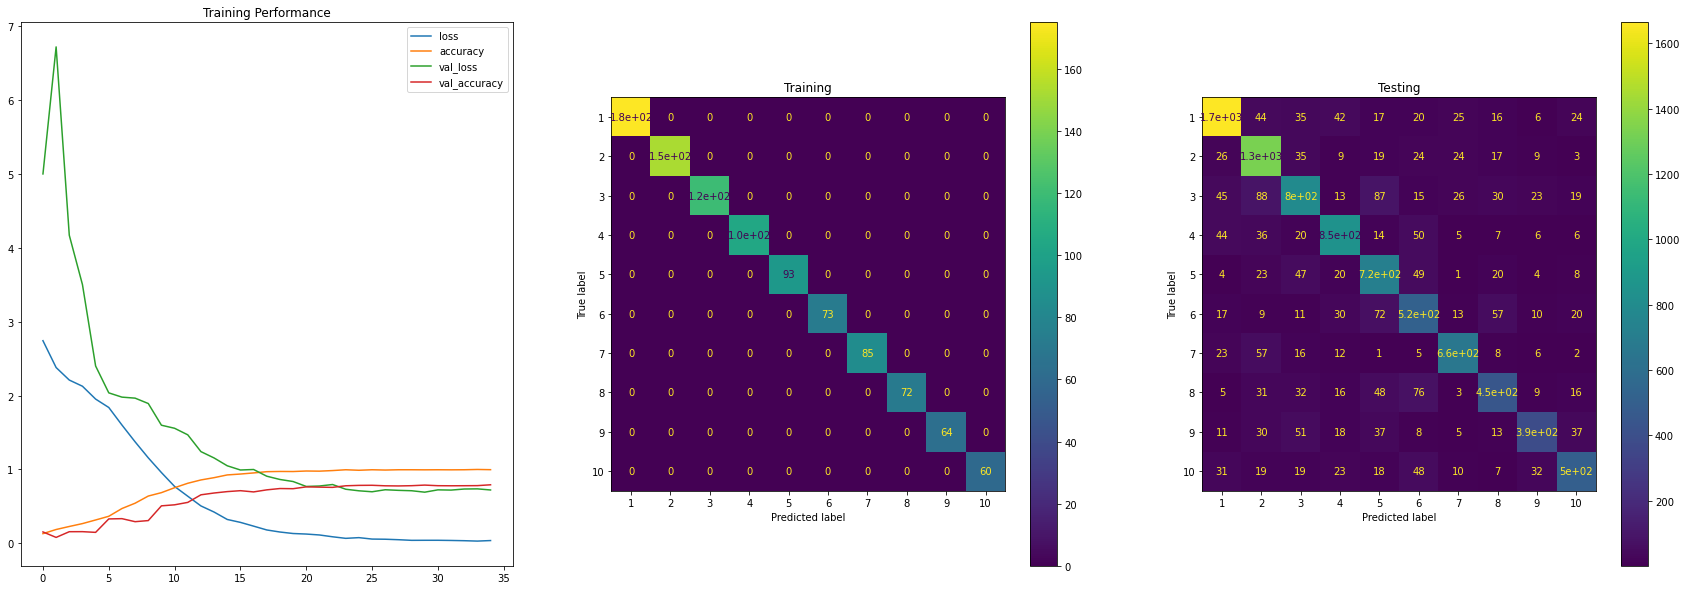

In [10]:
num_epochs = 35
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32,64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_3stage_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_3stage_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
train_and_eval(model_3stage_cnn, train, train_y, test, test_y, 'vgg_3stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 14s - loss: 0.6914 - accuracy: 0.7873
Test loss: 0.6913649127483368
Test accuracy: 0.7873


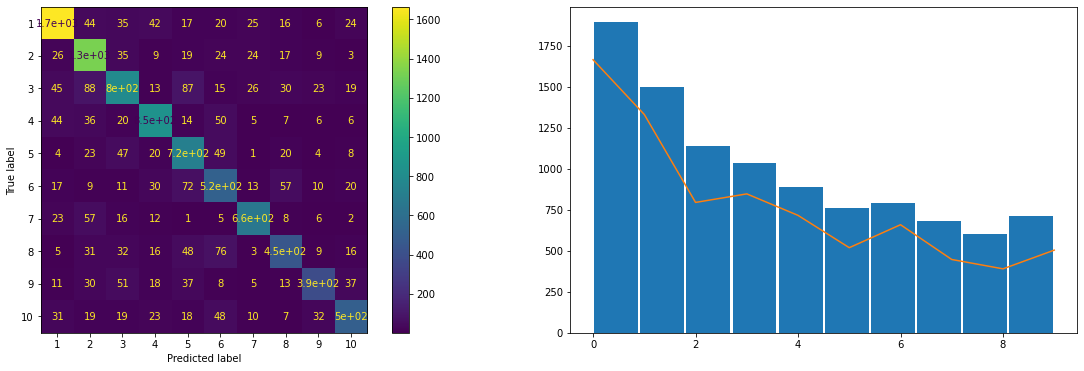

In [11]:
eval_model(model_3stage_cnn, test, test_y)

# Question 2
Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.

In [12]:
datagen = ImageDataGenerator(
                            # rotate between -10, +10 degrees
                            rotation_range=10,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for randomly applying a shearing transform
                            shear_range=0.05,
                            # range for zooming
                            zoom_range=0.05,
                            # don't allow horizontal flips of data
                            horizontal_flip=False,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

In [13]:
# batch = datagen.flow(train, train_y, batch_size=1000)

# new_train = numpy.append(batch[0][0],train, axis = 0)
# new_train_y = numpy.append(batch[0][1],train_y, axis = 0)
# batch2 = datagen.flow(train, train_y, batch_size=1000)
# new_train = numpy.append(batch2[0][0],new_train, axis = 0)
# new_train_y = numpy.append(batch2[0][1],new_train_y, axis = 0)
# print(new_train.shape)
# print(new_train_y.shape)

# fig = plt.figure(figsize=[10, 10])
# for i in range(100):
#     ax = fig.add_subplot(10, 10, i + 1)
#     ax.imshow((batch[0][0][i,:,:,:]).astype('uint8'))

In [14]:
# batch_size = 128
# num_epochs = 20
# 
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_augmented_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_augmented_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model_augmented_cnn.fit_generator(datagen.flow(train, train_y, batch_size=128),
                    steps_per_epoch=1000//128,
                    epochs=100,
                    validation_data=(test, test_y), verbose=False)
# fig = plt.figure(figsize=[20, 6])
# ax = fig.add_subplot(1, 2, 1)
# ax.plot(history.history['loss'], label="Training Loss")
# ax.plot(history.history['val_loss'], label="Validation Loss")
# ax.legend()

# ax = fig.add_subplot(1, 2, 2)
# ax.plot(history.history['accuracy'], label="Training Accuracy")
# ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
# ax.legend()
# train_and_eval(model_cnn, new_train, new_train_y, test, test_y, 'vgg_2stage_FashionMNIST_small_1.h5', batch_size, num_epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']


10000/10000 - 11s - loss: 0.6067 - accuracy: 0.8482
Test loss: 0.6066509483218193
Test accuracy: 0.8482


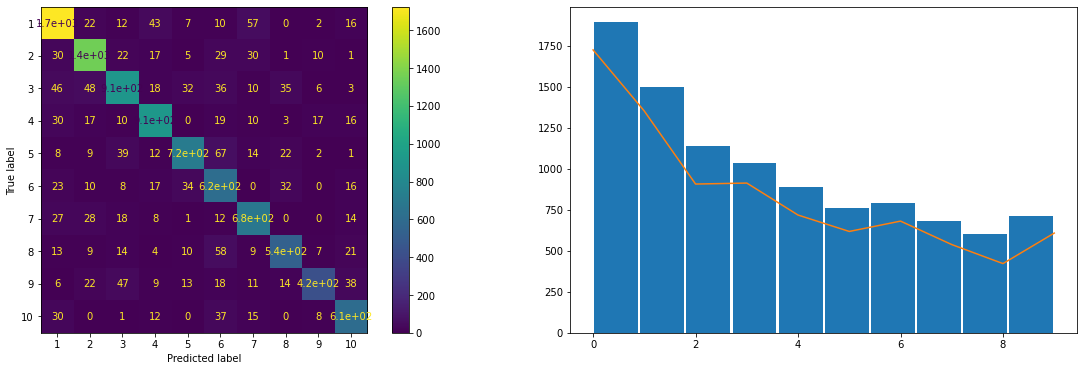

In [15]:
eval_model(model_augmented_cnn, test, test_y)

Text(0.5, 1.0, 'Training Performance')

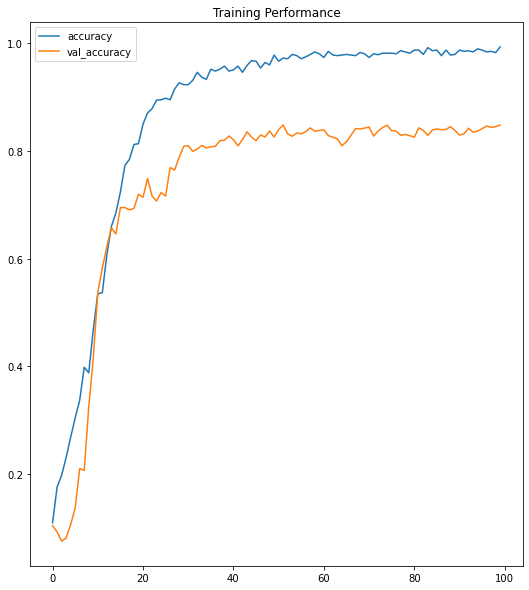

In [16]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
# plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()
ax.set_title('Training Performance')

In [17]:
model_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0

In [18]:
model_3stage_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0

In [19]:
model_augmented_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0